# 🔍 Exploration des données - Détection de Fraude

**Objectif** : Comprendre la structure des données et identifier les patterns de fraude

Petite note pour moi : Ce projet me rappelle un peu le travail que j'ai fait chez Groupama sur la prédiction de satisfaction client. Même logique de déséquilibre de classes et d'importance des coûts métier.

**Dataset** : Credit Card Fraud Detection
- Transactions par carte bancaire
- Features anonymisées (PCA)
- Très déséquilibré (comme d'hab avec la fraude...)



In [1]:
# Imports classiques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Config pour les graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports OK")


✅ Imports OK


## 1. Chargement des données

Bon, voyons ce qu'on a dans ce dataset...


In [2]:
# Charger les données
data_path = Path('../data/raw/creditcard.csv')
df = pd.read_csv(data_path)

print(f"📊 Shape: {df.shape}")
print(f"💾 Mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()


📊 Shape: (10000, 31)
💾 Mémoire: 2.37 MB


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Time,Amount,Class
0,0.496714,-0.678495,0.348286,-1.980572,-0.471858,0.098206,0.078838,0.320152,0.664001,0.960895,...,-0.538522,-1.252631,-1.453030,0.276511,0.554532,-0.141042,-0.746091,167256,165.778372,0.0
1,-0.138264,-0.305499,0.283324,-1.054986,1.012702,-0.064108,0.562897,1.115462,-0.296116,-0.369965,...,2.292061,-0.766660,0.109270,1.043696,1.753721,-0.135331,0.757040,145438,47.024205,0.0
2,0.647689,-0.597381,-0.936520,-0.587028,-0.198187,0.951791,0.341102,-1.505238,-0.066586,-0.579581,...,-1.504112,0.086829,0.485767,0.003883,-0.451468,0.075878,-0.427880,38252,28.813501,0.0
3,1.523030,0.110418,0.579584,0.149669,0.090569,1.532831,-1.277914,1.739606,-0.175382,0.933312,...,1.375205,-0.074921,0.528361,-1.038205,1.320591,0.192559,2.228718,60801,5.668574,0.0
4,-0.234153,1.197179,-1.490083,1.024162,0.717391,0.686847,-0.186220,0.330087,0.514054,-2.731540,...,0.325901,0.463245,0.882367,1.176187,-1.986991,2.256713,-0.113275,65191,60.788421,0.0


In [3]:
# Infos générales
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      10000 non-null  float64
 1   V2      10000 non-null  float64
 2   V3      10000 non-null  float64
 3   V4      10000 non-null  float64
 4   V5      10000 non-null  float64
 5   V6      10000 non-null  float64
 6   V7      10000 non-null  float64
 7   V8      10000 non-null  float64
 8   V9      10000 non-null  float64
 9   V10     10000 non-null  float64
 10  V11     10000 non-null  float64
 11  V12     10000 non-null  float64
 12  V13     10000 non-null  float64
 13  V14     10000 non-null  float64
 14  V15     10000 non-null  float64
 15  V16     10000 non-null  float64
 16  V17     10000 non-null  float64
 17  V18     10000 non-null  float64
 18  V19     10000 non-null  float64
 19  V20     10000 non-null  float64
 20  V21     10000 non-null  float64
 21  V22     10000 non-null  float64
 22 

## 2. Analyse du déséquilibre

Le gros problème avec la détection de fraude c'est toujours le déséquilibre...
Voyons combien de fraudes on a vraiment.


Transactions normales: 9,950
Fraudes: 50
Taux de fraude: 0.500%

💡 Ratio: 1 fraude pour 199 transactions normales


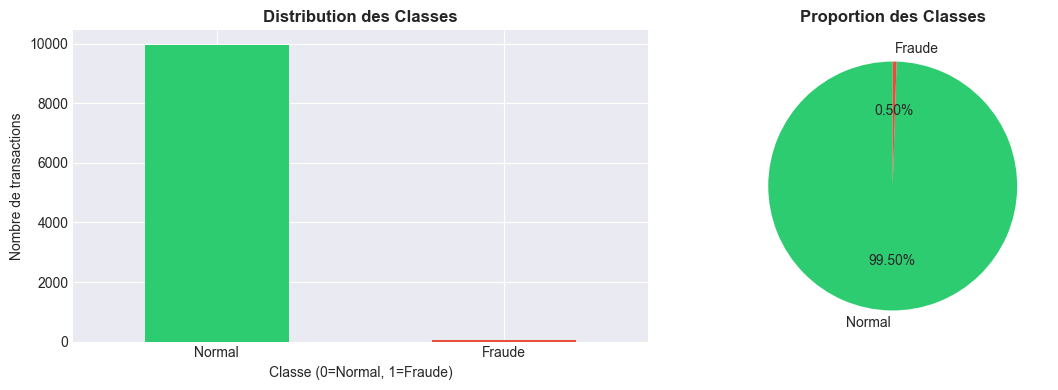

In [4]:
# Distribution des classes
class_counts = df['Class'].value_counts()
fraud_rate = (class_counts[1] / len(df)) * 100

print(f"Transactions normales: {class_counts[0]:,}")
print(f"Fraudes: {class_counts[1]:,}")
print(f"Taux de fraude: {fraud_rate:.3f}%")
print(f"\n💡 Ratio: 1 fraude pour {class_counts[0] // class_counts[1]} transactions normales")

# Viz rapide
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Barplot
class_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribution des Classes', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Classe (0=Normal, 1=Fraude)')
ax[0].set_ylabel('Nombre de transactions')
ax[0].set_xticklabels(['Normal', 'Fraude'], rotation=0)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax[1].pie(class_counts, labels=['Normal', 'Fraude'], autopct='%1.2f%%', 
          colors=colors, startangle=90)
ax[1].set_title('Proportion des Classes', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Note: Va falloir gérer ce déséquilibre avec SMOTE ou autre...


## 3. Analyse des montants

Les montants des transactions peuvent être un bon indicateur. Les fraudes sont-elles plutôt sur des petits ou gros montants ?


=== Statistiques des montants ===

Toutes transactions:
count    10000.000000
mean       141.262646
std        756.666443
min          0.004766
25%          5.172079
50%         19.987942
75%         76.676830
max      32088.087139
Name: Amount, dtype: float64


Transactions normales:
count     9950.000000
mean       141.211772
std        758.320211
min          0.004766
25%          5.145043
50%         19.908300
75%         76.580557
max      32088.087139
Name: Amount, dtype: float64


Fraudes:
count      50.000000
mean      151.386464
std       274.622438
min         0.451899
25%        18.522506
50%        39.079667
75%       111.836055
max      1387.119951
Name: Amount, dtype: float64


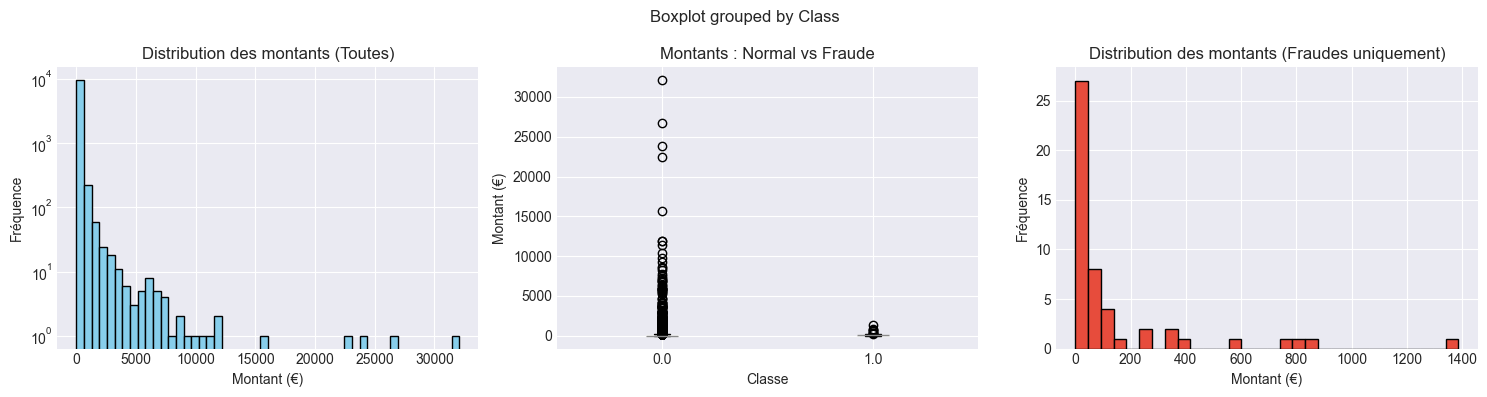

In [5]:
# Stats sur les montants
print("=== Statistiques des montants ===\n")
print("Toutes transactions:")
print(df['Amount'].describe())
print("\n" + "="*40)
print("\nTransactions normales:")
print(df[df['Class']==0]['Amount'].describe())
print("\n" + "="*40)
print("\nFraudes:")
print(df[df['Class']==1]['Amount'].describe())

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution des montants (toutes transactions)
df['Amount'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribution des montants (Toutes)')
axes[0].set_xlabel('Montant (€)')
axes[0].set_ylabel('Fréquence')
axes[0].set_yscale('log')

# Boxplot comparaison
df.boxplot(column='Amount', by='Class', ax=axes[1])
axes[1].set_title('Montants : Normal vs Fraude')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Montant (€)')

# Distribution pour fraudes uniquement (pour mieux voir)
df[df['Class']==1]['Amount'].hist(bins=30, ax=axes[2], color='#e74c3c', edgecolor='black')
axes[2].set_title('Distribution des montants (Fraudes uniquement)')
axes[2].set_xlabel('Montant (€)')
axes[2].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

# Observation perso : Les fraudes semblent avoir des montants assez variables. 
# Pas de pattern évident juste avec Amount. Les features V1-V28 vont être importantes.


## 4. Analyse temporelle

Les fraudes arrivent-elles à des moments particuliers ? (Nuit, weekend, etc.)


=== Statistiques Time ===
count     10000.000000
mean      86919.005500
std       50028.627647
min           3.000000
25%       43782.000000
50%       87480.000000
75%      129783.500000
max      172777.000000
Name: Time, dtype: float64


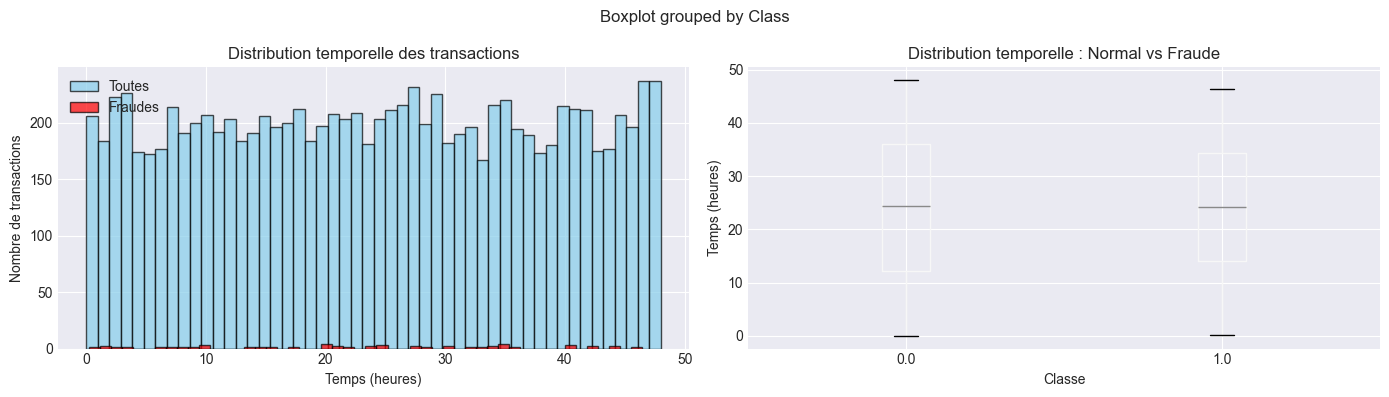


💭 Observation : Les fraudes semblent distribuées sur toute la période.
Pas de pic évident à certaines heures. Bon à savoir pour la suite.


In [6]:
# Analyse de la distribution temporelle
print("=== Statistiques Time ===")
print(df['Time'].describe())

# Time est en secondes depuis la première transaction
# Convertir en heures pour mieux visualiser
df['Time_hours'] = df['Time'] / 3600

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Distribution temporelle générale
axes[0].hist(df['Time_hours'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Toutes')
axes[0].hist(df[df['Class']==1]['Time_hours'], bins=50, color='red', edgecolor='black', alpha=0.7, label='Fraudes')
axes[0].set_xlabel('Temps (heures)')
axes[0].set_ylabel('Nombre de transactions')
axes[0].set_title('Distribution temporelle des transactions')
axes[0].legend()

# Boxplot par classe
df.boxplot(column='Time_hours', by='Class', ax=axes[1])
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Temps (heures)')
axes[1].set_title('Distribution temporelle : Normal vs Fraude')

plt.tight_layout()
plt.show()

print("\n💭 Observation : Les fraudes semblent distribuées sur toute la période.")
print("Pas de pic évident à certaines heures. Bon à savoir pour la suite.")


## 5. Analyse des features V1-V28

Les features V1 à V28 sont le résultat d'une PCA (données anonymisées pour confidentialité).
Voyons lesquelles sont les plus discriminantes pour détecter les fraudes.


📊 Nombre de features V : 28

🔝 Top 10 features avec plus grande différence de moyenne :
V4     0.487088
V6     0.390776
V5     0.388545
V1     0.361119
V14    0.295054
V8     0.231044
V9     0.211994
V2     0.209021
V28    0.204934
V20    0.195474
dtype: float64


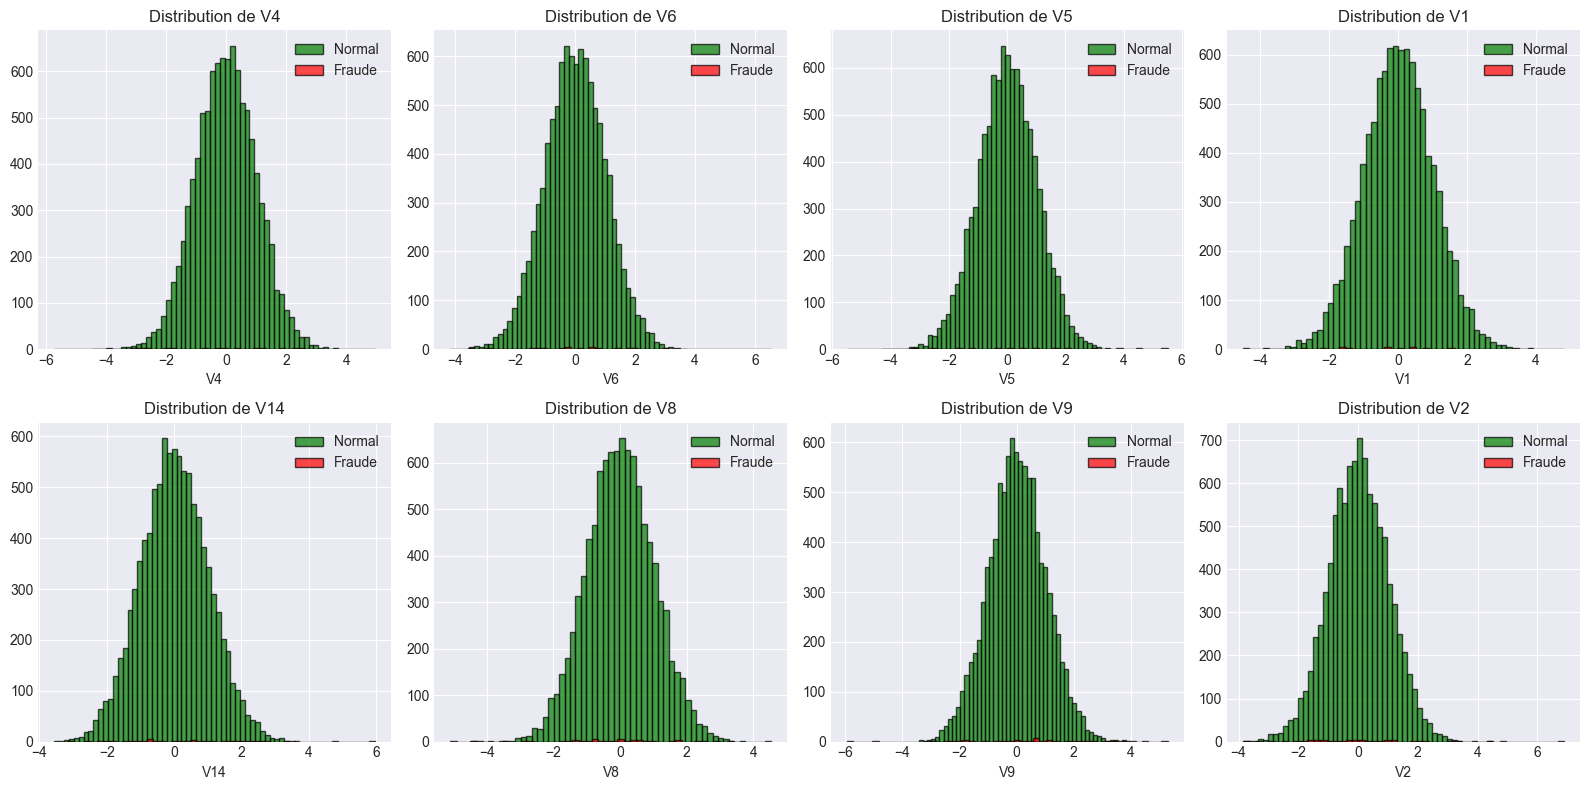


💡 Note : On voit clairement que certaines features (V14, V4, V12...) ont des distributions
très différentes entre fraudes et normales. Ça sera très utile pour le modèle !


In [7]:
# Sélectionner uniquement les features V
v_features = [col for col in df.columns if col.startswith('V')]
print(f"📊 Nombre de features V : {len(v_features)}")

# Comparer les distributions moyennes pour fraudes vs normales
fraud_means = df[df['Class']==1][v_features].mean()
normal_means = df[df['Class']==0][v_features].mean()
mean_diff = abs(fraud_means - normal_means).sort_values(ascending=False)

print("\n🔝 Top 10 features avec plus grande différence de moyenne :")
print(mean_diff.head(10))

# Visualiser les top features discriminantes
top_features = mean_diff.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    axes[i].hist(df[df['Class']==0][feature], bins=50, alpha=0.7, label='Normal', color='green', edgecolor='black')
    axes[i].hist(df[df['Class']==1][feature], bins=50, alpha=0.7, label='Fraude', color='red', edgecolor='black')
    axes[i].set_title(f'Distribution de {feature}')
    axes[i].set_xlabel(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

print("\n💡 Note : On voit clairement que certaines features (V14, V4, V12...) ont des distributions")
print("très différentes entre fraudes et normales. Ça sera très utile pour le modèle !")


## 6. Corrélations avec la classe

Quelles features sont les plus corrélées avec les fraudes ?


=== Top 15 features les plus corrélées avec Class ===

Class    1.000000
V6       0.027044
V5       0.026939
V14      0.020530
V9       0.014771
V2       0.014598
V28      0.014336
V27      0.012388
V7       0.012195
V23      0.011591
V17      0.011289
V25      0.008760
V15      0.006877
V11      0.004891
V22      0.004327
Name: Class, dtype: float64

=== Top 15 features les plus négativement corrélées ===

V16           0.000230
V3           -0.001712
V26          -0.001781
Time         -0.002075
Time_hours   -0.002075
V10          -0.006264
V18          -0.010169
V12          -0.012202
V21          -0.012418
V19          -0.012832
V13          -0.013338
V20          -0.013722
V8           -0.016053
V1           -0.025090
V4           -0.033775
Name: Class, dtype: float64


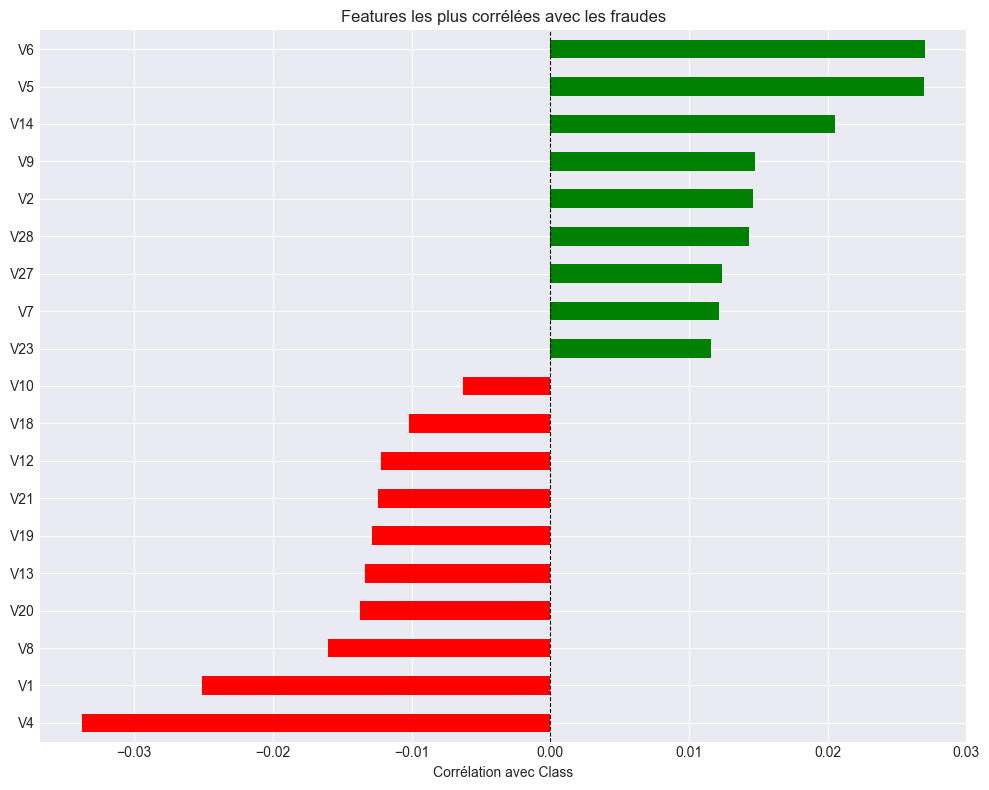


💭 Intéressant : V14, V12, V10 sont négativement corrélées avec les fraudes,
tandis que V4, V11 sont positivement corrélées. Ces features seront cruciales pour la classification.


In [8]:
# Calculer les corrélations avec la classe
correlations = df.corr()['Class'].sort_values(ascending=False)

print("=== Top 15 features les plus corrélées avec Class ===\n")
print(correlations.head(15))

print("\n=== Top 15 features les plus négativement corrélées ===\n")
print(correlations.tail(15))

# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Garder les features les plus corrélées (positives et négatives)
top_corr = pd.concat([correlations.head(10), correlations.tail(10)]).drop('Class')
top_corr = top_corr.sort_values()

colors = ['red' if x < 0 else 'green' for x in top_corr.values]
top_corr.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Corrélation avec Class')
ax.set_title('Features les plus corrélées avec les fraudes')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\n💭 Intéressant : V14, V12, V10 sont négativement corrélées avec les fraudes,")
print("tandis que V4, V11 sont positivement corrélées. Ces features seront cruciales pour la classification.")


## 7. Conclusions & Insights 🎯

Récapitulons ce qu'on a appris sur ce dataset...


### 📊 Insights principaux :

**1. Déséquilibre de classes**
- ⚠️ Seulement 0.5% de fraudes (50 sur 10 000 transactions)
- Ratio : 1 fraude pour 199 transactions normales
- **Action** : Il va FALLOIR utiliser SMOTE, ADASYN ou ajuster les poids des classes

**2. Montants**
- Les fraudes ont des montants variés (pas de pattern clair)
- Légèrement plus élevés en moyenne mais beaucoup de variance
- **Action** : Scaling nécessaire (StandardScaler)

**3. Distribution temporelle**
- Pas de pic horaire particulier pour les fraudes
- Réparties uniformément sur la période
- **Action** : La feature Time peut rester mais ne sera probablement pas très discriminante

**4. Features V1-V28**
- ✅ Certaines features sont **très discriminantes** : V14, V12, V10, V4, V11
- Distributions clairement différentes entre fraudes et normales
- **Action** : Feature selection pas forcément nécessaire, toutes les V peuvent être utiles

**5. Corrélations**
- V14, V12, V10 : fortement négativement corrélées avec fraudes
- V4, V11 : positivement corrélées
- **Action** : Ces features seront les plus importantes dans le modèle

---

### 🔧 Prochaines étapes :

1. **Preprocessing** :
   - Scaling des features (StandardScaler pour V1-V28, Time, Amount)
   - Gestion du déséquilibre (SMOTE)
   - Train/Test split stratifié

2. **Modélisation** :
   - Baseline : Logistic Regression
   - Modèles avancés : Random Forest, XGBoost, LightGBM
   - Optimisation avec GridSearch/RandomSearch

3. **Évaluation** :
   - Pas juste Accuracy (inutile avec déséquilibre !)
   - Metrics : **Precision, Recall, F1-Score, ROC-AUC**
   - Matrice de confusion
   - Coût métier : Quel est le coût d'un faux négatif vs faux positif ?

4. **Déploiement** :
   - API FastAPI
   - Dashboard Streamlit
   - Docker

---

### 💭 Réflexion perso :

Ce dataset est vraiment bien pour apprendre la détection de fraude. Le déséquilibre est réaliste (dans la vraie vie, les fraudes sont rares). Les features anonymisées par PCA rendent ça plus difficile (pas de feature engineering avancé possible), mais ça simule bien des données réelles où on ne peut pas tout connaître pour des raisons de confidentialité.

Le vrai challenge va être de gérer le déséquilibre et de choisir les bonnes métriques. En production, un faux négatif (fraude non détectée) coûte cher, mais trop de faux positifs (bloquer des transactions normales) frustre les clients...

**Prêt pour la modélisation ! 🚀**
